References :
- https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf
- https://towardsdatascience.com/with-the-emergence-of-social-media-high-quality-of-structured-and-unstructured-information-shared-b16103f8bb2e
- https://pypi.org/project/tweet-preprocessor/
- https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [1]:
#import necessary libraries
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
import glob

from wordcloud import WordCloud

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

<H2> Read Data </H2>

read zomato and swiggy tweets from csv folder (all 45 days of tweets)

In [2]:
swiggy = pd.DataFrame()
for file_name in glob.glob("data/swiggy/"+'*.csv'):
    df = pd.read_csv(file_name)
    swiggy = swiggy.append(df, sort=False)
swiggy['length'] = swiggy['full_text'].apply(len)

In [3]:
zomato = pd.DataFrame()
for file_name in glob.glob("data/zomato/"+'*.csv'):
    df = pd.read_csv(file_name)
    zomato = zomato.append(df, sort=False)
zomato['length'] = zomato['full_text'].apply(len)

In [4]:
#remove retweets, same tweets, tweets by self
print(swiggy.shape)
swiggy = swiggy[~swiggy['full_text'].str.startswith("RT")]
swiggy = swiggy.drop_duplicates(subset=['full_text'], keep="first")
swiggy = swiggy[~((swiggy['screen_name'] == 'swiggy_in') | (swiggy['screen_name'] == 'swiggyCares'))]
print(swiggy.shape)

(5879, 12)
(4653, 12)


In [5]:
swiggy.sample(5)

,date,favorite_count,followers_count,friends_count,full_text,retweet_count,retweeted,screen_name,tweet_id,user_id,user_mentions,length
1,2019-02-14 23:20:42,2,74,277,"@theboyinatux @Uber @swiggy_in Well, cooking a...",0,False,joshi_hemant_,1096187507295711232,836048942701826050,"['theboyinatux', 'Uber', 'swiggy_in']",291
46,2018-12-31 20:05:56,0,4,108,@swiggy_in New year pathetic start . Without e...,0,False,Amar30705366,1079831039122366464,944894852839366656,['swiggy_in'],300
196,2018-09-19 14:04:45,0,135,3,"@SwiggyCares Hello Mister whoever you are, Do ...",0,False,AbhishekOpines,1042414195034095618,4781932574,['SwiggyCares'],290
92,2018-10-31 18:14:32,0,138,1299,@SwiggyCares Reply to DM,0,False,MaheshGayii,1057697343653330945,137711748,['SwiggyCares'],24
55,2018-12-31 19:58:07,0,257,469,"@myGate_in Yeah, I understood the feature and ...",0,False,prateekwaghre,1079829072522371074,30633641,['myGate_in'],291


In [6]:
#remove retweets, same tweets, tweets by self
print(zomato.shape)
zomato = zomato[~zomato['full_text'].str.startswith("RT")]
zomato = zomato.drop_duplicates(subset=['date','full_text'], keep="first")
zomato = zomato[~((zomato['screen_name'] == 'zomatoIn') | (zomato['screen_name'] == 'zomatocare'))]
print(zomato.shape)
zomato.sample(5)

(5793, 12)
(4142, 12)


,date,favorite_count,followers_count,friends_count,full_text,retweet_count,retweeted,screen_name,tweet_id,user_id,user_mentions,length
70,2018-09-19 18:47:30,0,7816,166,@prajjwal_me @rajmeh65 @raja5290 @dinakaran @Z...,0,False,UfterYou,1042485351229665281,604291342,"['prajjwal_me', 'rajmeh65', 'raja5290', 'dinak...",142
58,2019-05-19 20:03:30,0,101,396,@Zomato @zomatocare @ZomatoIN Zomato couldnt h...,0,False,SookhaPuri,1130202339019698176,187472539,"['Zomato', 'zomatocare', 'ZomatoIN']",163
39,2018-10-14 19:14:46,0,15,116,@zomatocare @zomatocare Please check your DM f...,0,False,rpitrathi,1051551906978508801,1552590762,"['zomatocare', 'zomatocare']",200
13,2018-12-14 23:52:43,1,79,87,@KingDarius83 @HughJassoleLV @vikassri2 @zomat...,0,False,DondestaLaVida,1073727515225550848,1030288213401722881,"['KingDarius83', 'HughJassoleLV', 'vikassri2',...",322
77,2018-11-14 18:30:44,0,14,71,@zomatocare @ZomatoIN sab milke pagal bna rhe ...,0,False,shivamy80177253,1062774850308190208,2547784816,"['zomatocare', 'ZomatoIN']",144


In [7]:
#save raw data before doing further analysis
zomato.to_csv('data/zomato_raw.csv')
swiggy.to_csv('data/swiggy_raw.csv')

Check lengths of swiggy and zomato text

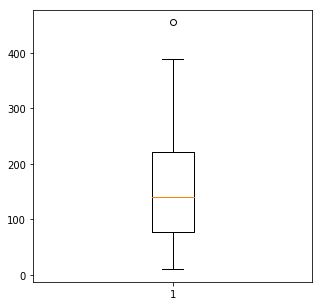

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(swiggy['length'])
plt.show()

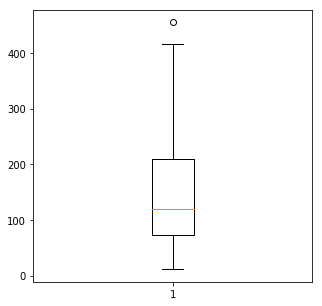

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(zomato['length'])
plt.show()

In [10]:
#Check sample tweets
swiggy['full_text'].sample(20)

1      @SwiggyCares I have spoken to one of your coll...
52     Looking at large number of  @swiggy_in bills i...
74     @SwiggyCares I am waiting for your call. @swig...
59     @SwiggyCares On calling cust care no. It said ...
127                @SwiggyCares it was not handles in DM
53     @SwiggyCares I wait for 45 minutes &amp; when ...
117    @SwiggyCares ordered waffle at 9.36 pm waited ...
14     @foodpandaIndia @ola_supports It's still same....
55     @SwiggyCares @FreshMenuIndia @UberEats_IND Hop...
157    @ankittweet13 @swiggy_in @SwiggyCares I think ...
45     I have been just told by @swiggy_in that go an...
116    @swiggy_in Pls kindly improve the customer car...
48     @swiggy_in Because of that, I had to order foo...
43     @swiggy_in @SwiggyCares hey contacts never lis...
86     @SwiggyCares I agree that you've refunded the ...
45     @swiggy_in haha.. now u don't have any replies...
84     @ZomatoIN @zomatocare indian  custmer is not b...
3      @GabbbarSingh And it's a

<H2>Clean data</H2>

In [11]:
import preprocessor as p

stop_words = set(stopwords.words('english'))
stop_words_list = list(stop_words)

extended_list = []
with open('stop_word_extended.txt') as f:
    extended_list.extend([word for line in f for word in line.split()])

stop_words_list.extend(extended_list)
stop_words_list.extend(['humans', 'water', 'may', 'nice', 'zomato', 'swiggy', 'order', 'food', 'say', 'im'])
stop_words_list = list(set(stop_words_list))

#remove stop words
def remove_stop_words(text) :
    word_tokens = word_tokenize(text)
    filtered_tokens = [w for w in word_tokens if not w in stop_words_list]
    return ' '.join(filtered_tokens)

#clean tweets for punctuations, numbers, # etc
def clean_tweets(text) :
    print(text)
    text = BeautifulSoup(text, 'lxml').get_text()
    try:
        text = text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = text
    
    text = re.sub(r'@[A-Za-z0-9_]+','',text)  #remove all @mention
    text = re.sub('https?://[A-Za-z0-9./]+','', text)  #remove links
    text = re.sub("[^a-zA-Z\s]", "", text)  #remove all #, numbers, etc non alphabets
    text = text.lower().strip() #lowercase and strip
    text = re.sub(' +', ' ', text) #all double spaces with single
    
    text = text.replace('delivered', 'delivery')
    text = text.replace('deliver', 'delivery')
    text = text.replace('deliveryy', 'delivery')
    text = text.replace('customers', 'customer')
    text = text.replace('guys', 'guy')
    text = text.replace('boy', 'guy')
    
    text = remove_stop_words(text)
    #text = p.clean(text)
    print(text + "\n\n")
    return text

In [12]:
#print original text and clean text
swiggy['clean_text'] = swiggy['full_text'].apply(lambda x: clean_tweets(x))

@SwiggyCares Thank you 👍
thank


@swiggy_in The answer is Terry Wilmeth #LightningFastQuiz
@vidyathapa76 @Sanjiv_34 @iPriyankaNaik @nitin_cul @ammy_l2012 @KukrejaShubhs #Bhubaneswar #Contest #ContestAlert https://t.co/mQykLJalfK
answer terry wilmeth lightningfastquiz bhubaneswar contest contestalert


@swiggy_in The answer is 1357.64 km/hr #LightningFastQuiz
@vidyathapa76 @Sanjiv_34 @iPriyankaNaik @nitin_cul @ammy_l2012 @KukrejaShubhs #Bhubaneswar #Contest #ContestAlert https://t.co/eLVLL4GpNL
answer kmhr lightningfastquiz bhubaneswar contest contestalert


@swiggy_in The answer is A3-Juno Spacecraft
#LightningFastQuiz
@vidyathapa76 @Sanjiv_34 @iPriyankaNaik @nitin_cul @ammy_l2012 @KukrejaShubhs #Bhubaneswar #Contest #ContestAlert https://t.co/12OgOPdhnR
answer ajuno spacecraft lightningfastquiz bhubaneswar contest contestalert


@swiggy_in The answer is Shackey Jackey Italian Greyhound #LightningFastQuiz
@vidyathapa76 @Sanjiv_34 @iPriyankaNaik @nitin_cul @ammy_l2012 @KukrejaShubhs #Bh

chinese firm isko toh sabak sikhana hi hoga


@SwiggyCares I need solution.
solution


@SwiggyCares Check DM



@SwiggyCares Hi! I want to know about my refund status. You told I will get in 4 days, it is more than a week still waiting for it.
hi refund status week waiting


@IampraPrashanth @vik21_yadav @TajinderBagga @KapilSharmaK9 @swiggy_in @SwiggyCares @Syska_LED @RedmiIndia Tu khud kar na kaamchor.
tu khud kar na kaamchor


@TajinderBagga @NitinUploader @KapilSharmaK9 @swiggy_in @SwiggyCares @Syska_LED @RedmiIndia sony channel ko boycott karna best idea hai. Now it's better to boycott under pay as u use theme. #BoycottSonyTV
sony channel ko guycott karna best idea hai better guycott pay theme guycottsonytv


@TajinderBagga @KapilSharmaK9 @swiggy_in @SwiggyCares @Syska_LED @RedmiIndia Bagga goto fast......
bagga goto fast


#BoycottKapilSharma #boycottkapilsharmashow #BoycottSonyTV #boycottsidhu #UnsubscribeSonyTV @swiggy_in @Syska_LED @RedmiIndia @SonyTV https://t.co/CgDUmrkJTS
g

app shows delivery within min received tweet poorcustomerervice poorserviceswiggy customerdissatistfaction notthefirsttime


Ordered through @Zomato, delivered by @swiggy_in  ? 🤔 https://t.co/WKfjP8DWkl
delivery


@oldschoolmonk Kholo @Zomato  ya @swiggy_in
kholo ya


@swiggy_in Illusive delivery service!

Disclose the mechanism of
 delivery charge?
illusive delivery service disclose mechanism delivery charge


Request all to NOT download the @SwiggyCares @swiggy_in app, their system automatically sends you a minimum of 100 sms's every day, despite tall promises they are absolutely rubbish, they just dont act to resolve the problem
request download app system automatically sends minimum smss every day despite tall promises absolutely rubbish act resolve problem


@SwiggyCares By when do you propose to come up with the Call Back and more importantly a solution.
Really poor customer support.
Waiting for an early reply(though that's a myth with Swiggy) else i dropping a mail to the Consum

quantity full size honey chilli chicken worst ever spent shift great jobs


@SwiggyCares Check again and revert
revert


@SwiggyCares Nothing is added I have checked it.
nothing added


@SwiggyCares credit promised of 75 but now given yet. Order NO 19856980452. Chat person said some error coming. ALSO YOUR SUPPORT IS NOT WORKING NOW.
credit promised given person error coming support working


@SwiggyCares What about Guntur🙄
guntur


@swiggy_in  @foodpandaIndia @UberEats_IND CONGRATS GUYS. One out. Now I hope the game is between real players.(🌚= "hope is a big word my friend")
#coldzomato @Zomato https://t.co/ElQTrtyhFR
congrats guy hope game real players hope big word friend coldzomato


@karan0712 @swiggy_in Akele akele khaoge to yahi hoga.. ye sale youtube se fursat paye tab na...
akele akele khaoge yahi hoga ye sale youtube se fursat paye tab na


@SwiggyCares Never eating there again. If they refuse to even acknowledge they've had a lapse in hygiene, can you image how many more dis

cnnot pain going bye bye


@swiggy_in @SwiggyCares 
Wow that was superfast response from Srikant.
I hope you guys take this seriously.
https://t.co/qB2HjgC9U8 https://t.co/oOWKZzTPbF
wow superfast response srikant hope guy seriously


@SwiggyCares Thank you @SwiggyCares for resolving the issue!
thank resolving issue


@SwiggyCares What you ll do i have the fking refund.
fking refund


@rohitroy500 @dominos Got a dozen dash cam videos of @swiggy_in guys talking and riding scooter/bikes dangerously
dozen dash cam videos guy talking riding scooterbikes dangerously


@SwiggyCares Partner support ? M not a restaurant owner. I am customer.
partner support restaurant owner customer


@swiggy_in ordr 16135735090 rsvishalsingh93@gmail.com
Ordrd @11:38 delivry time 57 mins.Its 12:50 &amp;app says its delivrd nd fone of delivry guy is off.
Disapointd and hungry and whats your atitude,tak ur f'king refnd and get lost.
Compltly lost me today.
@foodpandaIndia @ZomatoIN
ordr rsvishalsinghcom ordrd de

horrible experience customer executive says cancelled irritating customer service experience ever


@thehitarthsoni @UberEats @UberEats_IND @Zomato @swiggy_in rocks
rocks


@swiggy_in @SwiggyCares Please extend your services to enable us to take benefit of your spectacular work. https://t.co/VZAnoCmTKP
extend services enable benefit spectacular work


@zomatocare @Zomato @swiggy_in Let it be bro , had a bad night because of this :-(
let bro bad night


@Gaur_says @Zomato @swiggy_in Hey  man, apologies for the delay. Getting this checked right away.
-TJ
man apologies delay tj


@SwiggyCares @swiggy_in



@swiggy_in what a great reply from swiggy now. They say its not our fault that you got the bad quality of food, its restaurant's fault..So may i please know that how did we reached to restaurant through swiggy only, the platform is swiggy..
great fault bad quality restaurants faultso reached restaurant platform


@swiggy_in @Zomato @foodpandaIndia @UberEats If I was given an option to c

updates


@SwiggyCares I just twitted my order no ,, kindly check
twitted


I have not recived my complete order even i was told that it doesn’t matter the voucher i use but the cart item value and i was given delight gift from resturant but i have been not give this time @SwiggyCares @swiggy_in kindly justify https://t.co/Sl7HxYv5sV
recived complete doesnt matter voucher cart item value given delight gift resturant time justify


@SwiggyCares My order is not delivered but in your app it is showing delivered. How it is possible. https://t.co/ktdz0MuQBx
delivery app showing delivery possible


@swiggy_in @SwiggyCares any explanation why this restaurant is charging double of MRP. A mini pet with MRP of Rs. 20 is being sold for Rs. 40 on your platform. Care to explain. Attached pic for reference. https://t.co/5pDtZYbtIr
explanation restaurant charging double mrp mini pet mrp sold platform care explain attached pic reference


Thanks a lot @SwiggyCares for resolving issue faster and  being

issue received bad quality complained executive deny yo close immediately complaining foid quality twitter sending bad executive service


Ordered from @Zomato @ZomatoIN waffle from last of my penny, guy called me once nd I couldn't pick up the phone. Called him just after a minute, nd he cancelled the order. Wht m I supposed to do? Also, zomato levied the full amount. I m hungry, don't have money! @swiggy_in
waffle penny guy called nd couldnt pick phone called minute nd cancelled wht supposed levied full amount hungry money


Relax .@swiggy_in ... there are much worse things that delivery team can do ... 

https://t.co/Qy4hRgJE73
relax worse things delivery team


@SwiggyCares Sorry man @zomatocare gave me my order in 13 mins ... Your customer care is impotent. In an another issue when I got 50% of content of what it used to be, Ur ccare did nothing. I see them listing same dish. So the hope is gone. Thanks @Zomato for satisfying my hunger during 12 am
sorry man gave mins customer car

ago update dominos tried chatting person gave min tried calling agents kept passing buck agent finally woke cancellation charges levied sir wow glad


Seriously worst service ever 
@SwiggyCares @swiggy_in  @dominos @dominos_india
seriously worst service ever


@SwiggyCares it is what I got when I ordered from swiggy . No help received I have waited for several minutes . They became blind serving anything restaurant provide just to make profit. It is complete unhygienic order I have received. https://t.co/htGdTOcxf5
received waited several became blind serving anything restaurant make profit complete unhygienic received


@swiggy_in Where's my food?
Your customer service executives are pathetic. I had been waiting for food for more than an hour with the delivery executive's location right next to my house for 15 mins and no response from him in calls. Your support executive was the worst ive seen.
wheres customer service executives pathetic waiting delivery executives location next hous

note regd mobile


@SwiggyCares Yes my contact no 8510091112
yes contact


@bhaad_me_jao @swiggy_in help her out.



@SwiggyCares Only sorry for wasting my money and not providing my food , very dissapointed
sorry wasting money providing dissapointed


@SwiggyCares Nobody reached out to me!
nobody reached


@swiggy_in hi plz don't ordering food by Swiggy very pathantic customer care service . If food is in not eatable condition than also customer responsible as per Swiggy support
hi pathantic customer care service eatable condition customer responsible per support


@SwiggyCares You guys don't care at all!! Still awaiting a response from your side!
guy care awaiting response side


@SwiggyCares The issue has been amicably resolved. Swiggy definitely needs more employees like Ashish that lend an empathetic ear to the customer and deliver quick result. 
Thank you.
issue amicably resolved needs employees ashish lend empathetic ear customer delivery quick result thank


@ZomatoIN  @zomatoc

bye bye lost customer almost everyday user


@swiggy_in money deducted but can’t find status of my order. Help
money deducted find status


. @Zomato @ZomatoIN charged me 640 odd for the order cancelled with in 2 mins. Gross cheating. Will never use zomato again. I asked them to send order again instead of paying the cancellation charges. But they're saying it's not possible. @swiggy_in is the best. Bye bye zomato. https://t.co/owkZOidEJk
charged odd cancelled mins gross cheating never asked send instead paying cancellation charges theyre saying possible best bye bye


@swiggy_in new policy... To get food order within 1 km otherwise you won’t get it...Really pathetic
policy within km otherwise wont itreally pathetic


@SwiggyCares Do you even know what the issue is @harshamjty @nandanreddy @swiggy_in
issue


@SwiggyCares @swiggy_in what's the hell? Still no help https://t.co/fq1nODQmbw
whats hell


Dear sir.                                                                 I placed order


No @SwiggyCares I don't want your apology when the food that I had paid for was not worth consuming for me. I am not paying you to send me food that is of no use absolutely.

So please, keep your apology and refund my money. I cannot fill my stomach with your apology. @swiggy_in https://t.co/34fPcrpx9A
apology paid worth consuming paying send absolutely keep apology refund money fill stomach apology


@SwiggyCares should change the tagline from super lightning delivery to super slow delivery.@swiggy_in..learn something from @ZomatoIN
change tagline super lightning delivery super slow deliverylearn something


@SwiggyCares Yes proceed
yes proceed


@SwiggyCares DMed. Please check.
dmed


One of worst experience with @ZomatoIN @zomatocare . Got no call and they have cancelled the order and then they have guts not refund the money. @swiggy_in and @UberEats_IND are way better with some ethics. #zomatofails
worst experience cancelled guts refund money better ethics zomatofails


@SwiggyCar




@SwiggyCares Bull, have sent my guard to find your aimless delivery boy. This definitely shows that you haven't equipped your delivery boys with equipment to delivery promptly and also reflects on your poor training standards. PERIOD!
bull sent guard find aimless delivery guy shows havent equipped delivery guys equipment delivery promptly reflects poor training standards period


@swiggy_in very poor delivery services at mumbai location
poor delivery services mumbai location


@deepigoyal @zomatocare Deep Goyal first improve ur service then claim all this, return my money deducted by fraud means

@SwiggyCares  should teach you few things on customer service

Hope u understand there is a reason why zomato orders also get delivered with swiggy branding:p
deep goyal first improve service claim return money deducted fraud means teach things customer service hope reason delivery brandingp


@dominos_india Hi. Ordered via @swiggy_in, haven't received order but Dominos app shows it's deliv

completed refund gone send link permanently closing account consumer court


@WeAreSwiggy @SwiggyCares @swiggy_in What are you guys up to? Delivering non veg items for veg orders? Do you guys have any responsibility of checking the content of the order before delivery?
Just sorry won't work for a pure vegetarian here atleast!
#understandyourolesfirst
guy deliverying non veg items veg guy responsibility checking content delivery sorry wont work pure vegetarian atleast understandyourolesfirst


@swiggy_in @SwiggyCares @WeAreSwiggy is unable to understand my query still... https://t.co/YdkTiRSqxF
unable query


@SwiggyCares See you also left conversation in between, I was aware about that
left conversation aware


@SwiggyCares these guys are proving me wrong even inspite of the fact what the menu says
guy proving wrong inspite fact menu says


@SwiggyCares Just the matter of this tweet and swiggy triggered me a message showing me my refund, with correct amount and order ID which was said 

In [13]:
#print original text and clean text
zomato['clean_text'] = zomato['full_text'].apply(lambda x: clean_tweets(x))

@zomatocare @ZomatoIN And Zomato is refunding 87₹ for an order value of 345₹ which was not delivered. Why ?
refunding value delivery


@ZomatoIN what kind of pathetic customer service is this. Order number 1203389227 https://t.co/zxY8Fv2SWE
kind pathetic customer service


@zomatocare @ZomatoIN Am done for now. Tired and sleepy. Call me after 3 pm tommorow. Will explain you in detail
done tired sleepy tommorow explain detail


@zomatocare @ZomatoIN Please



Stupidity of @ZomatoIN customer support. They give credits for missing items and then say outlet gave full order. Wow. https://t.co/IoXaVcqJ1C
stupidity customer support credits missing items outlet gave full wow


That's savage. @ZomatoIN you should send a job offer to the @NetflixIndia Social Media Manager... https://t.co/YOrL6zZyaw
savage send job offer social media manager


Another order frm @ZomatoIN n another issue.
1. Had to take my activa n pick d order coz god knws what happened to riders phne.
https://t.co/LOcD5lIZTV fri

received hot delivery guy refused talked support guy throw eatable


I reviewed Second Wife Restaurant and rated it 3/5 on @ZomatoIN #LoveFood https://t.co/2vu3KtrIPk
reviewed second wife restaurant rated lovefood


@zomatocare  I ordered (order Id 1306704089) today though Zomato Restaurant Name The Kalika Hut Lucknow order showing confirmed but rider not deliver my order when i take to help to Zomato care or Restaurant they also not able to help me and i weast my Money.. https://t.co/C2uhBzJV2K
though restaurant name kalika hut lucknow showing confirmed rider delivery care restaurant able weast money


@Zomato @ZomatoIN @zomatocare @fssaiindia @ndtv @ZeeNews @JPNadda

Zomato you are still not learning from your mistakes !! Delivery is lack of basic food security measures. This how I have received the order and customer care denied to callback !! ID 1679230928. NO FOOD SAFETY https://t.co/mnOXsS5JQE
learning mistakes delivery lack basic security measures received customer care denied c

reviewed jetlag rated lovefood


@ZomatoIN has been the posterboy of shit food for a long time now. 

@Zomato  transforms the dish into a filthy snacks with shit-filled dishes and charge customers for it.
posterguy shit long time transforms dish filthy snacks shitfilled dishes charge customer


@Zomato just got cold!  

Introducing SHITPACKS ⚡@ZomatoIN – Food that was never fresh!  

Whether you are new to the party or a social butterfly - there is a pack for everyone!
cold introducing shitpacks never fresh whether party social butterfly pack everyone


Me: 
Mom! what the hell! You made a dog shit food today!

Mom: 
Shut up! Mind your language! 
I ordered you food from @zomato @ZomatoIN  @zomatocare!

#fakefood #nofood #zerozomato
mom hell made dog shit mom shut mind language fakefood nofood zerozomato


@zomatocare 1516393868
I am sick and tired of these robots that u have in customer support sending me automated replies. Arrange a call back for me right away if u don’t want further e

keep waiting


I reviewed Khatta Meetha Teekha Tadka and rated it 4/5 on @ZomatoIN #LoveFood https://t.co/6iqrQroBRx
reviewed khatta meetha teekha tadka rated lovefood


I reviewed Burn - Bar &amp; Kitchen and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/BwifjYEVRT
reviewed burn bar kitchen rated lovefood


@heman_174 @ZomatoIN @MajesticManja Yes... they follow only one rule.. sudharenge nahi hum kabhi bhi.. bas lootenge apne regular customers ko
yes follow rule sudharenge nahi hum kabhi bhi bas lootenge apne regular customer ko


@zomatocare @Zomato @ZomatoIN why is nobody interested to talk to my tweet ? Am i not a customer ?
nobody interested talk tweet customer


@ZomatoIN I wait for my order where is the delivery boy then cancel the order why https://t.co/jUKCxUJQ11
wait delivery guy cancel


@Zomato @ZomatoIN @zomatocare are you guys sleeping? It's been 30 mins I'm waiting for my 1 soft drink bottle. How long should I wait for you to assign one agent to just get that delivere

hi someone social media team assured issue solved nothing happened person touch hasnt answerd calls false promieses r made treat partners


@zomatocare @Zomato @ZomatoIN Thanks for prompt response.let me know In case you need the audio recording of the delivery guy . I have a recording where he said that I dnt like to wear the t shirt. So come to main road to pick the parcel.
thanks prompt responselet case audio recording delivery guy recording dnt wear shirt come main road pick parcel


@zomatocare We are very disappointed that we placed an order at 9:38 and we were told that it would be delivered at 10:28 but now its 10:45 and we are still waiting for the order .Do not take the order if you fannot deliver on time VERY DISAPPOINTED! .   [order number-1534339264]
disappointed delivery waiting fannot delivery time disappointed


@ZomatoIN We are very disappointed that we placed an order at 9:38 and we were told that it would be delivered at 10:28 but now its 10:45 and we are still waiti

supposed provided credits compensation


@UberEats_IND @Anilkalalk @swiggy_in @ZomatoIN nothing's gonna happen Anil.
there are around 2000 customers cheated in the same way buly #ubercheats 
follow me with 
#ubercheats
#uberfrauds2018
#boycottuber
#notouber
share with all ur whatsapp contacts
to never get fallen into trap of ubercheats
nothings gon na happen anil around customer cheated buly ubercheats follow ubercheats uberfrauds guycottuber notouber whatsapp contacts never fallen trap ubercheats


Hey @ZomatoIN @Zomato. Please let me know how to report condescending customer service / support agents. I have an issue to file.
let report condescending customer service support agents issue file


I reviewed Cafe Chokolade and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/MMPIdyM9XK
reviewed cafe chokolade rated lovefood


I reviewed Parleshwar Vada Pav Samrat and rated it 4/5 on @ZomatoIN #LoveFood https://t.co/4p1xd9jH8o
reviewed parleshwar vada pav samrat rated lovefood


I reviewe

service level terrible run business


@Zomato @ZomatoIN @zomatocare https://t.co/V8oeC1PL4Z



@ZomatoIN even after 1 hour of order, it is still in kitchen and your customer support guys wants to wait for more hours at this time. Is this a Zomato policy? Or your guys not aware of existing policies? https://t.co/dVkMWggaDU
kitchen customer support guy wants wait time policy guy aware existing policies


@ZomatoIN @zomatocare what the hell is your service??? I was promised delivery at 1.12 am and it's been 1.59 and I haven't gotten my order yet no help from chat support had been done. I want refund for this order. So disappointed right now https://t.co/WhWr2E3yA9
hell service promised delivery havent gotten support done refund disappointed


@ZomatoIN @zomatocare It has been a while now that the delivery person marked my order delivered and it has not been delivered by now. Your executive told me that he is providing complimentary order and he left. No reply nothing. I bought treats memb




@zomatocare @Zomato Just making me fool &amp; nothing else.

Such a bad experience with zomato will never suggest anyone for using zomato. They said we will be calling you shortly but no call till yet nd its about 1 hour and above. Thinking customers as an owl nd fool too. 9999998123 https://t.co/UemTKEU2GB
making fool nothing else bad experience never suggest anyone using calling shortly till nd thinking customer owl nd fool


@ZomatoIN I've been waiting for you guys to get back to me on chat for half an hour now. Your support people promptly disappeared after the compulsory "hi". Is this sorry statebhownyou treat your paying customers?
ive waiting guy half support people promptly disappeared compulsory hi sorry statebhownyou treat paying customer


Okay so sorry twitter for wasting your time. I just searched #zomato and all i can find is Upset customers. So thanks @zomatocare for your 1 precious automated msg(of no use). 
@Zomato 
#zomatodontcare #coldzomato #sadzomato #sadme #sad

top head genetics medications chemo psychological factors diseases hypothyroidism insulin resistance polycystic ovary syndrome cushings syndrome


@TheatreChick76 @Ven1_V1di_V1c1 @jgourav28 @YourStoryCo @Zomato @ZomatoIN “You’ve never been so hungry you committed a crime” he’s employed, it’s not like he can’t afford cheap corner food. Sit down yourself
youve never hungry committed crime hes employed afford cheap corner sit


@The_Unlocked @YourStoryCo @Zomato @ZomatoIN "what do my eyes tell me is happening?" Just believe in yoursmelf
eyes tell happening believe yoursmelf


@veit2coffee @zomatocare @rose_k01 @ZomatoIN @Zomato Is not the employers responsibility to feed their employees. No job does. MAYBE look into their salary, but that aside, this is completely unethical, not to mention disgusting. I was homeless for many years, this never crossed my mind to do
employers responsibility feed employees job maybe salary aside completely unethical mention disgusting homeless many years nev




@Zomato @zomatocare @ZomatoIN absolute pathetic service. Its shows meet ur valet at door 16 mins ago and still 20mins eta showing. Ordered at 1020pm and no msg from your customer service. Absolutely pathetic https://t.co/SlYvKR5jM1
absolute pathetic service shows meet valet door mins ago mins eta showing msg customer service absolutely pathetic


That’s what I am telling these ppl do not give a shit about the customer support. I have already done #uninstallzomato.. shame on @ZomatoIN https://t.co/qjTyS2oPEk
telling ppl shit customer support already done uninstallzomato shame


@zomatocare @ZomatoIN Still waiting for refund
waiting refund


@zomatocare @Zomato @ZomatoIN Have DM'd.
dmd


@zomatocare please help!! https://t.co/MYQsuGLKMF



I reviewed Chili's Grill &amp; Bar and rated it 1/5 on @ZomatoIN #LoveFood https://t.co/clHFF1IH8d
reviewed chilis grill bar rated lovefood


@zomatocare #hardearnmoney
hardearnmoney


@zomatocare I really can't understand . I have shared the photog

customer service delivery guys uselessreply


@zomatocare @ZomatoIN @Zomato @deepigoyal @mohitcharu https://t.co/x1Hcbaprti



@zomatocare @ZomatoIN @Zomato @deepigoyal @mohitcharu How convenient it is for your CS to stop responding
convenient cs stop responding


@Zomato @ZomatoIN @zomatocare 
I have ordered this ...see what I have got ...I want my money to be refunded ! https://t.co/WmdHgzusuI
money refunded


@zomatocare @ZomatoIN Can you plz check your DM and reply to me there as until and unless I don’t get any satisfaction I don’t won’t to ruin your brand openly
unless satisfaction wont ruin brand openly


@zomatocare I ordered food and have not received it yet after 1 hour. The restaurant says food is ready, nobody here to pick it up. The delivery guy says he is not assigned the delivery. What to do? Order ID 1128259796
received restaurant says ready nobody pick delivery guy says assigned delivery


@zomatocare @ZomatoIN This is a complaint about your customer service; the chat 

complained customer care agent hung listening complain uttering repeated words regret wont happen


Pathetic deliver and customer service by @Zomato Declined an order after an hour of receiving it past the expected delivery time.  Really disappointed by @ZomatoIN @zomatocare @deepigoyal.  No wonder Swiggy is way ahead in customer experience.
pathetic delivery customer service declined receiving past expected delivery time disappointed wonder ahead customer experience


@zomatocare @Zomato Did you miss a "not" in your reply?
miss


@zomatocare 1279592516 order number



Hi @ZomatoIN @zomatocare I have ordered chicken mushroom soup and chicken wontons. They mixed egg yellow in soup nd a stinky smell is coming from it and wontons tastes horrible, I felt like eating sand. Please help me in this regard!
hi chicken mushroom soup chicken wontons mixed egg yellow soup nd stinky smell coming wontons tastes horrible felt eating sand regard


@JagoGrahakJago_ @deepigoyal @zomatocare
Hi Sir ordern

done


@zomatocare @Zomato @ZomatoIN @RadioMirchi Awaiting your response... 

@Avni19980 @twerpingsilly
awaiting response


@zomatocare Being a food blogger i can understand your concern @kkshitizsingh this is just unprofessional service by @ZomatoIN https://t.co/JrcqYXLD0l
blogger concern unprofessional service


@zomatocare pathetic service https://t.co/h9415odaD3
pathetic service


I reviewed Young Chilli and rated it 4/5 on @ZomatoIN #LoveFood https://t.co/3vnui3gBPO
reviewed young chilli rated lovefood


@zomatocare I need a proper compensation for this stupid service by @ZomatoIN how can you cancel an order after accepting it that too when it's time for closure of all restaurants in city. it's criminal by @ZomatoIN 
Zomato linked mail-kshitiz7007@gmail.com https://t.co/NYOWmDJ7Sh
proper compensation stupid service cancel accepting time closure restaurants city criminal linked mailkshitizcom


@twerpingsilly @sudip6980 @zomatocare @Zomato @ZomatoIN @RadioMirchi @swiggy_in Hahaha s




@ZomatoIN @Zomato @zomatocare @ZomatoGold I don't want to continue with the existing plan
continue existing plan


@ZomatoIN @zomatocare reached the GPS location. I question him that he just told me that the GPS location was incorrect post which I asked him to reach Ashok Nagar and call me for further directions, he says 'Sir main location pe pahunch gaya hun, aa ke le lo khana'. I question
reached gps location question gps location incorrect post asked reach ashok nagar directions says sir main location pe pahunch gaya hun aa ke le lo khana question


@ZomatoIN @Zomato @zomatocare @ZomatoGold I bought the 700 RS plan thinking it will give me 10 unlocks at every partner restaurant till I exhaust 10 unlocks at every partner restaurant. Also there is no FAQ which explains the new limited unlock plans. I got fooled. Any possibility I can switch to yearly membership ??
bought plan thinking unlocks every partner restaurant till exhaust unlocks every partner restaurant faq explains limite

message answer pathetic service


@ZomatoIN @zomatocare @Zomato



@zomatocare @Twitter



@zomatocare Im tired. No response from both restaurant and zomato.
tired response restaurant


@ZomatoIN 

I need answer for this.
Is zomato policy says like this? 
If the delivery was taken care by restaurant. Irrespective of customer received the order or not, after 2 hours order will be marked as delivered.
Find the chat screenshots attached with your agent n answer https://t.co/Bza2HYHsZ6
answer policy says delivery taken care restaurant irrespective customer received marked delivery find screenshots attached agent answer


@ZomatoIN Dear zomato are you really concern about your customers??  I have ordered item but instead i have received another .. contacted your support but didn't got any reply.. https://t.co/NVIz1QwvZF
dear concern customer item instead received another contacted support


@zomatocare It sorted just now, 3 hours later. I got my refund. Still, thanks for the refund. I hope 

bje complain kiya frauds abi tk ni kiye


@Rishabh81948925 @zomatocare looters hai sb...
looters hai sb


@i_surbhichawla @zomatocare @Zomato @SwiggyCares I m also very disappointed with t service of zomato, specially food packing. I already uninstalled this app. From few days I m using swiggy app. Swiggy service &amp; tempered proof packaging is very good. https://t.co/b365gslVHz
disappointed service specially packing already uninstalled app using app service tempered proof packaging good


@zomatocare Twitter p kuch likh do toh @ZomatoIN  instant reply karte ho ..  haramio custmer service provide karoge toh khule m galia nai khani padegi
twitter p kuch likh toh instant karte ho haramio custmer service karoge toh khule galia nai khani padegi


@zomatocare Ghanta . Raat ko ek baje khana tera baap order  tera baap dega muje . Ye bata .aur customer care walo ko paise nai dete kya ..
ghanta raat ko ek baje khana tera baap tera baap dega muje ye bata aur customer care walo ko paise nai det

hi charging extra kulfi executive taxes guy add tax kulfi


@AunindyoC @zomatocare @Zomato I thought you taught them some economics😁😁😁😁 because jaise aap batate ho detail me waisa maybe UPSC coaching wale padhate hai.....Future secure hai apka bhaisaab
thought taught economics jaise aap batate ho detail waisa maybe upsc coaching wale padhate haifuture secure hai apka bhaisaab


@zomatocare @Zomato Do look into this properly. Asap
properly


@vivekbrahminme @zomatocare @Zomato I have no idea. I didn't listen. I was busy preparing for Simple Samachar. I was just being polite.
idea listen busy preparing simple samachar polite


@zomatocare Still no response from the team of zomato after so many times I have tweeted them and mailed and msg on chat support regarding my refund which was initiated on 13 october...
9971198752.
response team many times tweeted mailed msg support regarding refund initiated october


@zomatocare I have complained a hundred times regarding so many issues, can you 

play


@ZomatoIN 
Focus on money rather than customer! Trick of Zomato loved it!
focus money rather customer trick loved


@zomatocare I need alt number of customer for order no 1330589849
alt customer


@zomatocare @ZomatoIN The chat wait time has been showing as 1 minute for 30 mins now. When I placed the order, the delivery time was 11.15, now the delivery time is showing as 11.52 PM.
wait time showing minute mins delivery time delivery time showing


@zomatocare @ZomatoIN Order No. 1533750938



@ZomatoIN I have been waiting for 25 minutes for a response on the Zomato Chat - help! My order is delayed by 45 mins.
waiting response delayed mins


@NJKTiwari @Zomato @ZomatoIN 19:00 hours, I meant! 

95 long hours &amp; cold food though!
meant long cold though


@zomatocare @Zomato @ZomatoIN yet no issue is resolved  nd no call nd reply came yet..  @SwiggyCares @swiggy_in  nd @foodpandaIndia  u guys are far better than from @Zomato
issue resolved nd nd came nd guy far better


@zomatoca

thing good company zomatochatservice guarantee delivery certainly takes care refund case discrepancies occurred


@ZomatoIN Very bad experience. Have got stale food. And no reply from customer service.
bad experience stale customer service


@ZomatoIN @zomatocare @Zomato  cheated me. I ordered 320 RS . Applied coupon of 100rs and they didn't sent me item of 100rs but only of 220Rs. Support said they cannot help. Delivery boy not picking call
cheated applied coupon sent item support delivery guy picking


Worst service ever , customers are betrayed with the service !! 
No response for the money we pay and the customer number don't work @Zomato @ZomatoIN
worst service ever customer betrayed service response money pay customer work


No response on chat also.. Poor customer service.. I didn't expect that from a brand like Zomato @zomatocare
response poor customer service expect brand


@Being_Ganesh @ZomatoIN @zomatocare Same thing here also bro. I was also totally disappointed with them.

stand cheating pathetic service zomatosucks


@deepigoyal @zomatocare Deep Goyal first improve ur service then claim all this, return my money deducted by fraud means

@SwiggyCares  should teach you few things on customer service

Hope u understand there is a reason why zomato orders also get delivered with swiggy branding:p
deep goyal first improve service claim return money deducted fraud means teach things customer service hope reason delivery brandingp


@zomatocare @deepigoyal 1607892138



@zomatocare Idiotic service, fraud restaurants and pathetic customer support sums up zomato

Wish the funding stops so that we all get relieved of this torture

#zomatosucks
idiotic service fraud restaurants pathetic customer support sums wish funding stops relieved torture zomatosucks


@zomatocare @Zomato Guess u guys are not going to understand things properly 

Let's meet in consumer court now
guess guy going things properly lets meet consumer court


@montugarg1 @RoflRavish @swiggy_in @foo

sir shared contact information


@ZomatoIN see what @foodpandaIndia is doing. https://t.co/zD7NB3PHXu



@zomatocare @ZomatoIN Order ID 1243801548 send me a pizza asap we've been waiting for over two hours now
send weve waiting two


@ZomatoIN my friend n I ordered a pizza and ur delivery boy gave it to someone else without confirming, it was already paid for this is the kind of service u guys provide?
friend delivery guy gave someone else confirming already paid kind service guy


@zomatocare @thebharatseva @ZomatoIN @Zomato My mobile number 8619083145
mobile


@thebharatseva @zomatocare @ZomatoIN @Zomato @zomatocare @ZomatoIN @Zomato did not get any reply till now. Where are you? I also mailed you.
till mailed


@zomatocare @ZomatoIN I had sent a DM before tweeting this but then I knew for a fact that you will surely not respond until it is HIGHLIGHTED. So check my DM !!
sent tweeting knew fact surely respond highlighted


I reviewed Karim's and rated it 4/5 on @ZomatoIN #LoveFood ht

issue certainly odd case painful deal disappointed


@Zomato @ZomatoIN FYI, there's no supervisor at your center and no one to solve the query's which are beyond your agent. 
Would request you to short this out as i have a pending escalation from your end. And yes he is very rude.
How can you leave it all on a such a rude agent?? https://t.co/9B3APyrZLt
fyi theres supervisor center solve querys beyond agent request short pending escalation yes rude leave rude agent


@swiggy_in When r u guys coming to Belgaum ?. .@ZomatoIN  already announced their entry
r guy coming belgaum already entry


@zomatocare @ZomatoIN @Zomato Cashback credited
cashback credited


@zomatocare @ZomatoIN @Zomato Thanks for the kind gesture
thanks kind gesture


@deepigoyal @ZomatoIN @zomatocare Today I had order chicken Biriyani through Zomato app and I have received biriyani without chicken and I have informed same thing in Zomato chat but they are saying that they can’t help.I have not got food tonight.
Order 

phones conked impact doesnt remember pretty dazed accident


@Zomato @zomatocare @ZomatoIN Since I have not received a single call from you guys even after asking for it so many times, I'll narrate the incident here. I ordered food from a place called Night Hawks through online payment at approx 1.54 Am which they accepted immediately. https://t.co/fFgzMabVYP
since received single guy asking many times ill narrate incident place called night hawks online payment approx accepted immediately


He had trouble speaking but said his name was Sachin. He is currently in Government Medical College Hospital, Nagpur. His phone wasn't working either. Police have been informed. Please look into it? @zomatocare @ZomatoIN
trouble speaking name sachin currently government medical college hospital nagpur phone wasnt working either police informed


Hi @zomatocare Want to inform you that one of your zomato delivery guys met with an accident. This happened around 2AM, near Kendrya Vidayalaya High School

In [14]:
#remove empty tweets after cleaning
zomato = zomato[zomato['clean_text'] != ""]
swiggy = swiggy[swiggy['clean_text'] != ""]
print(zomato.shape)
print(swiggy.shape)

(3654, 13)
(4415, 13)


In [15]:
zomato.to_csv('data/zomato.csv')
swiggy.to_csv('data/swiggy.csv')

<H3> Final Data </H3>

In [16]:
zomato_text = '\n'.join(zomato['clean_text'])
zomato_text = zomato_text + '\n'
text_file = open("data/zomato.txt", "w")
text_file.write(zomato_text)
text_file.close()

swiggy_text = '\n'.join(swiggy['clean_text'])
swiggy_text = swiggy_text + '\n'
text_file = open("data/swiggy.txt", "w")
text_file.write(swiggy_text)
text_file.close()

In [17]:
swiggy_corpus = ''.join(swiggy['clean_text'])
zomato_corpus = ''.join(zomato['clean_text'])

<H3> Initial Analysis </H3>

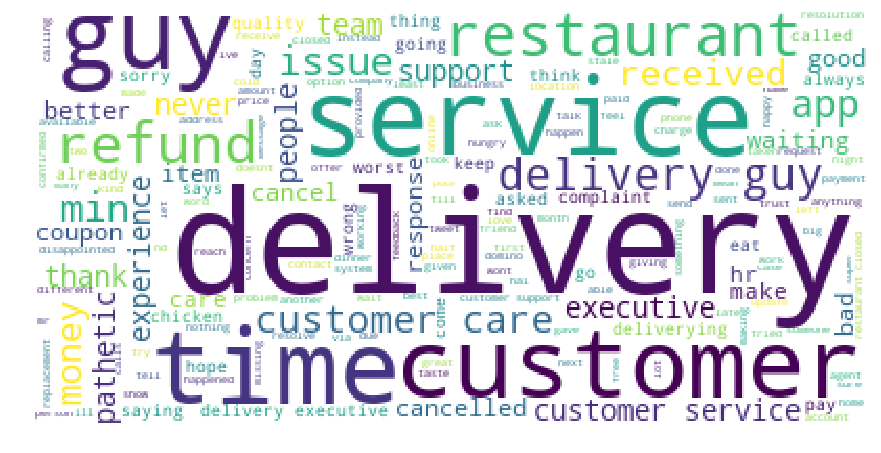

In [18]:
swiggy_word_tokens = word_tokenize(swiggy_corpus)
swiggy_corpus = ' '.join(swiggy_word_tokens)
cloud = WordCloud(background_color="white").generate(swiggy_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

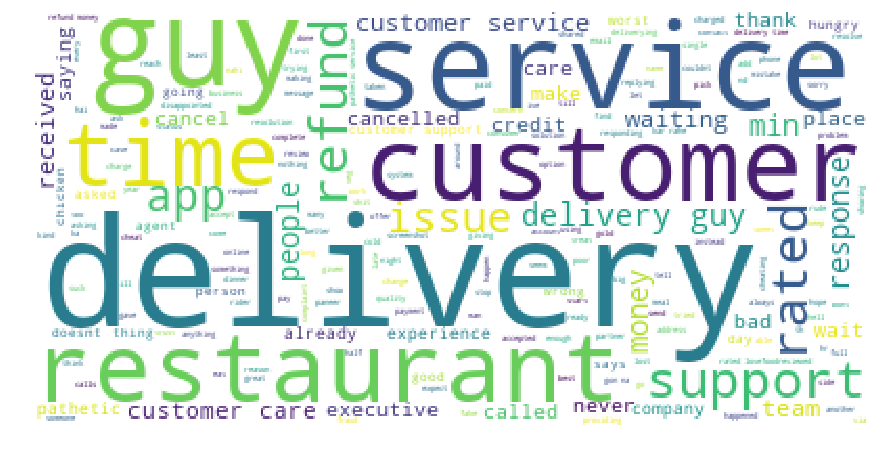

In [19]:
zomato_word_tokens = word_tokenize(zomato_corpus)
zomato_corpus = ' '.join(zomato_word_tokens)
cloud = WordCloud(background_color="white").generate(zomato_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

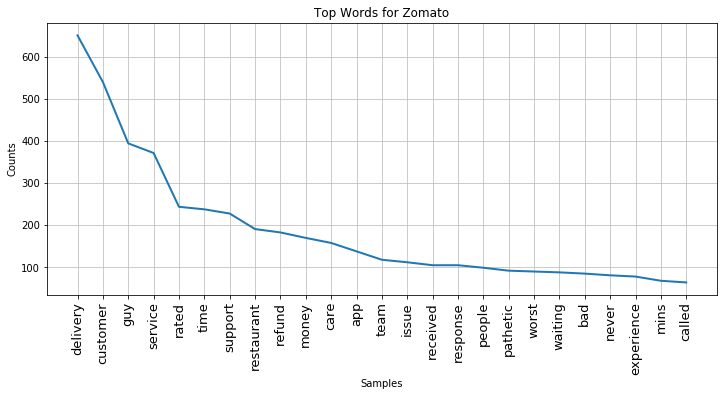

In [20]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(zomato_word_tokens)
fd.plot(25,cumulative=False, title='Top Words for Zomato')

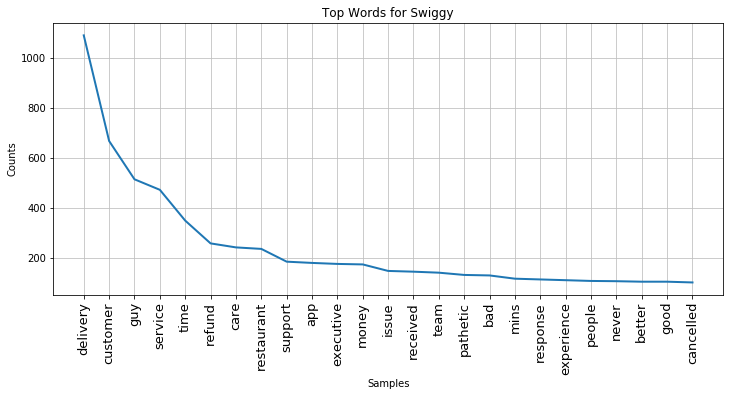

In [21]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(swiggy_word_tokens)
fd.plot(25,cumulative=False, title='Top Words for Swiggy')